## Description

In this notebook, we perform a slight processing of our alignments (for steps 9 and 11 of the graphical workflow / steps P7, P10 of the described pipeline).   
We discard constant columns, gappy columns, gappy/short sequences.   
We save the results in another directory.   

## Modules

In [1]:
from Bio import AlignIO
import os
from path import Path
from matplotlib import pyplot as plt
import numpy as np
from hgt_algorithms import *

## Data:

Input variables; modify for different stages of the pipeline

In [2]:
raw_alignment_dir = Path('second_round_raw_alignments')
processed_alignment_dir = Path('second_round_processed_alignments')

In [5]:
alignment_files = os.listdir(raw_alignment_dir)

In [6]:
print('Number of found alignment files:', len(alignment_files))

586

## Main processing

Note: The cell below will **remove contents** of `processed_alignment_dir` and replace them with newly processed alignments.  

In [ ]:
print('Processing %i alignments in' % len(alignment_files), raw_alignment_dir)
print('Saving alignments in', processed_alignment_dir)
try:
    os.mkdir(processed_alignment_dir)
except FileExistsError:
    dir_contents = os.listdir(processed_alignment_dir)
    for f in dir_contents:
        os.remove(processed_alignment_dir + '/' + f)

written_aln = 0
written_seq = 0
raw_ncols = []
raw_nrows = []
processed_ncols = []
processed_nrows = []
for i, f in enumerate(alignment_files):
    A = AlignIO.read(raw_alignment_dir/f, 'fasta')
    raw_nrows.append(len(A))
    raw_ncols.append(A.get_alignment_length())
    A = process_alignment(A, remove_constant_columns=True,
                             min_row_nb_of_aa=20, 
                             max_column_gap_proportion=.8, max_row_gap_proportion=.75)        
    processed_ncols.append(A.get_alignment_length())
    processed_nrows.append(len(A))
#         if len(A) <= 150:
#             AlignIO.write(A, odir/f, 'fasta')
#             written_aln += 1
#             written_seq += len(A)
    AlignIO.write(A, processed_alignment_dir/f, 'fasta')
    written_aln += 1
    written_seq += len(A)
print('Written %i alignments with %i sequences' % (written_aln, written_seq))
print()
print('Results of processing alignments:')
print('Number of sequences before processing:', sum(raw_nrows))
print('Number of sequences after processing:', sum(processed_nrows))
print('Discarded', sum(raw_nrows)-sum(processed_nrows), 'sequences and', sum(raw_ncols)-sum(processed_ncols), 'columns')
print('Shortest alignment (seqnb) before processing:', min(raw_nrows))
print('Shortest alignment (seqnb) after processing:', min(processed_nrows))
print('Shortest alignment (colnb) before processing:', min(raw_ncols))
print('Shortest alignment (colnb) after processing:', min(processed_ncols))
print()

Check if we need to discard some alignments because of the removal of sequences:

In [ ]:
sum(l<4 for l in processed_nrows)

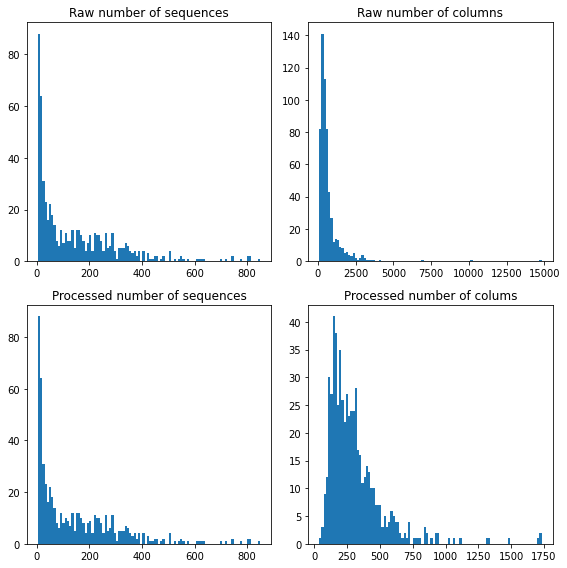

In [10]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.title('Raw number of sequences')
plt.hist(raw_nrows, bins=100)
plt.subplot(222)
plt.title('Raw number of columns')
plt.hist(raw_ncols, bins=100)
plt.subplot(223)
plt.title('Processed number of sequences')
plt.hist(processed_nrows, bins=100)
plt.subplot(224)
plt.title('Processed number of colums')
plt.hist(processed_ncols, bins=100)
plt.tight_layout()
plt.show()

In [11]:
print('Widest processed alignment:', alignment_files[np.argmax(processed_ncols)])
print('Widest raw alignment:', alignment_files[np.argmax(raw_ncols)])
print('Longest processed alignment:', alignment_files[np.argmax(processed_nrows)])

Widest processed alignment: Cluster_253.fa.aln
Widest raw alignment: Cluster_114.fa.aln
Longest processed alignment: Cluster_40.fa.aln


It's worth checking manually the alignments above to spot any potential bugs and artifacts of the analysis.   
You can use e.g. JalView for that.   
You may also want to write additional tests, but they won't replace looking at the results.   

## Examples of additional manual analyses of alignments for quality assessment   
This is not essential - the computations were performed in the previous section.   
However, it's a good practice to take a look at the results at each stage of the analysis.   
Below are some examples how to do it.  

Check if any alignment contains gaps.   
Why? For example if you use an alignment trimming software before this notebook and want to check its results. GBlocks with default settings will not leave any gaps in the alignment, this is usually too strict.   

In [ ]:
for i, f in enumerate(alignment_files):
    A = AlignIO.read(raw_alignment_dir/f, 'fasta')
    if any('-' in seq for seq in A):
        gapped_alignment = A
        break

In [ ]:
print(i, f)
print(gapped_alignment)

Get the distribution of alignment lengths.   
Why? To check if you have extremely long alignments that will take forever to compute and will be super unreliable in this kind of analysis (they're usually caused by single excessively long proteins caused by ORF prediction errors, rather than actually families of long proteins)

In [ ]:
aln_lengths = [AlignIO.read(raw_alignment_dir/f, 'fasta').get_alignment_length() for f in alignment_files]

In [ ]:
plt.figure()
plt.hist(aln_lengths, bins=60)
plt.show()

In [ ]:
min(aln_lengths)

Check the number of short alignments:

In [ ]:
sum(l < 30 for l in aln_lengths)

Get the length distribution after discarding constant columns, and numbers of unique sequences.   
Why? To check how much this kind of filtering influences your results.   

In [ ]:
new_lengths = [0]*len(alignment_files)
number_of_sequences = [0]*len(alignment_files)
number_of_unique_sequences = [0]*len(alignment_files)
for i, f in enumerate(alignment_files):
    A = AlignIO.read(raw_alignment_dir/f, 'fasta')
    discard_constant_columns(A)  # this is a script from hgt_algorithms
    new_lengths[i] = A.get_alignment_length()
    number_of_sequences[i] = len(A)
    number_of_unique_sequences[i] = len(set(a.seq for a in A))

In [ ]:
plt.figure()
plt.hist(new_lengths, bins=60)
plt.show()

In [ ]:
min(new_lengths)

In [ ]:
sum(l < 20 for l in new_lengths)

In [ ]:
# number_of_duplicates = [a-u for a,u in zip(number_of_sequences, number_of_unique_sequences)]

In [ ]:
plt.figure()
plt.hist(number_of_sequences, bins=40)
plt.show()

Check alignments with large numbers of sequences.  
Why? Because you don't want too many of them, and that's because they will take exponentially forever to compute. And they will have errors - because each additional leaf is a potential error. You may need to filter your results more if you have many alignments with, say, more than 300 or 400 sequences. Or use a computing cluster, but I wouldn't recommend this path - increasing the computing power won't let you escape the harsh reality of imprecise data.     

In [ ]:
max(number_of_sequences)

In [ ]:
sum(x>=400 for x in number_of_sequences)

In [ ]:
sum(x >= 4 and x <= 400 for x in number_of_sequences)

In [ ]:
number_of_unique_sequences[number_of_sequences.index(max(number_of_sequences))]

In [ ]:
# # A = AlignIO.read(raw_alignment_dir/alignment_files[number_of_sequences.index(max(number_of_sequences))], 'fasta')
# A = AlignIO.read(raw_alignment_dir/alignment_files[42], 'fasta')
# print(A)

In [ ]:
# A2 = process_alignment(A)
# print(A2)

In [ ]:
# gaps = set()
# chars = set()
# for a in A2:
#     gaps.add(sum(char == '-' for char in a.seq))
# for j in range(A2.get_alignment_length()):
#     chars.add(len(set(A[:,j])))
# gaps

In [ ]:
# plt.figure()
# plt.hist(number_of_unique_sequences, bins=40)
# plt.show()

In [ ]:
# plt.figure()
# plt.hist(number_of_duplicates, bins=40)
# plt.show()

Check the impact of removing constant columns on discarding sequences.   
Why? Because we delete columns first and then check the sequences; deleting columns decreases the numbers of amino acids in sequences; the sequences may end up having less than the required number of amino acids and get discarded. We want to check if that actually happends, when, and how often.   

In [31]:
raw_ncols = []
raw_nrows = []
processed_ncols = []
processed_nrows = []
for i, f in enumerate(alignment_files):
    A = AlignIO.read(wdir/f, 'fasta')
    A1 = process_alignment(A, remove_constant_columns=False,
                             min_row_nb_of_aa=10, 
                             max_column_gap_proportion=.8, max_row_gap_proportion=.9)        

    A2 = process_alignment(A, remove_constant_columns=True,
                             min_row_nb_of_aa=10, 
                             max_column_gap_proportion=.8, max_row_gap_proportion=.9)
    if len(A1) > len(A2):
        break
print('Found it!')

Processing 2011 alignments in first_round_raw_alignments/I1.7
Found it!


In [19]:
print(A1)

Alignment with 112 rows and 1762 columns
--------------------------------------------...--- AIA82461.1
--------------------------------------------...--- ALL97694.1
-MEY-----------DIESEDDAA-ESGAQENQ------ES---...--- AWH61386.1
----------------MGGPLT----AAGGRGDGGAKAVEP-PP...--- BAD34005.1
--------------------------------------------...GCS BBH10044.1
-MNS----------------------------------------...--- CAA0407670.1
--------------------------MSLMEL------------...GCS CAB4291254.1
MEHSPE--------------------MGLTALDHSPEKTQSPPN...GCS CAB4321571.1
-MQI---------------------LTTSDREDDVV--------...--- CCA68807.1
-MED----------------------------------------...--- CDQ61940.1
--------------------------------------------...--- EEC75643.1
-MDS----------------------------------------...--- EFH41535.1
-MSD-----------YVAGSLVNDRVMEGNLNNSTTEVIED---...--- ESZ96850.1
-MQSQEEPPPK----------------TNSIDHH-------HGS...GGP EXB74915.1
-MHQPE-NPLKRTFNEMNSDPSN---MDLEYHDQTAAASNN---...DDS GAV80701.1
-MTS---KPSDLRIN--------

In [20]:
print(A2)

Alignment with 113 rows and 1760 columns
--------------------------------------------...--- AIA82461.1
--------------------------------------------...--- ALL97694.1
-MEY-----------DIESEDDAA-ESGAQENQ------ES---...--- AWH61386.1
----------------MGGPLT----AAGGRGDGGAKAVEP-PP...--- BAD34005.1
--------------------------------------------...GCS BBH10044.1
-MNS----------------------------------------...--- CAA0407670.1
--------------------------MSLMEL------------...GCS CAB4291254.1
MEHSPE--------------------MGLTALDHSPEKTQSPPN...GCS CAB4321571.1
-MQI---------------------LTTSDREDDVV--------...--- CCA68807.1
-MED----------------------------------------...--- CDQ61940.1
--------------------------------------------...--- EEC75643.1
-MDS----------------------------------------...--- EFH41535.1
-MSD-----------YVAGSLVNDRVMEGNLNNSTTEVIED---...--- ESZ96850.1
-MQSQEEPPPK----------------TNSIDHH-------HGS...GGP EXB74915.1
-MHQPE-NPLKRTFNEMNSDPSN---MDLEYHDQTAAASNN---...DDS GAV80701.1
-MTS---KPSDLRIN--------

In the example above, only two constant columns were removed (on top of many gapped columns that were removed as well), and this difference of two columns caused a removal of an additional sequence.  
Let's check the sequence.   

In [23]:
removed = [i for i, s in enumerate(A2) if s.id not in [ss.id for ss in A1]]
print(removed)

[40]


In [26]:
print(A2[40].seq)

-MAS------------------------------------------------------------------------------------------------------------------------------------KRSATSKAQW---------LHSHPEKVQQILNHKKDTIENMMMDPLNANSHSMKS------------------------------------------------------------TDN--------------------------------------------------------------------------------------------------------------------------------SS-------------------------------------------------YN---D---------------------------------------------------IPLVNSIRLGQTHPLL--------------NTHIKFD--------IEDENND----------------------------------------------------NDNKINN-----------------------------KMN------------------------------------------------------------EKGKEKD-----------------------------------------------------------------------------------------------------------------------KEKEKEKENYTTK------------------------------------------------------------------------------------------------------------------------------------------------------------------------

It's rubbish anyway, so we can afford losing it.   
It's now worth checking other sequences on top of that and running a qualitative analysis of how often this happens.   